**OBJECTIVE:** Introduce the notion of pre-trained models using HuggingFace

**AUTHOR:** [@jonjoncardoso](https://github.com/jonjoncardoso)

**LAST UPDATED:** 20/02/2022

# Imports

Import libraries and initialise variables that will be re-used throughout this notebook

In [3]:
import os
import wget
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tqdm
from tqdm.notebook import tqdm_notebook
tqdm_notebook.pandas()

from plotnine import * # This package emulates ggplot2 syntax, an R package, in python

%matplotlib inline

# Download data

We will be using data curated on the repository [several27/FakeNewsCorpus](https://github.com/several27/FakeNewsCorpus).

The cell below downloads all the data to the `../data` directory:

In [2]:
# common_url = "https://github.com/several27/FakeNewsCorpus/releases/download/v1.0/news.csv.z%02d"

# for i in tqdm.tqdm(range(1, 9+1)):
#     wget.download(common_url % i, out="../data/")

  0%|                                                                                             | 0/9 [00:00<?, ?it/s]

 99% [................................................................... ] 1073266688 / 1073741824

 11%|█████████▎                                                                          | 1/9 [02:36<20:55, 156.90s/it]

 99% [................................................................... ] 1073348608 / 1073741824

 22%|██████████████████▋                                                                 | 2/9 [04:50<16:42, 143.17s/it]

 99% [................................................................... ] 1073725440 / 1073741824

 33%|████████████████████████████                                                        | 3/9 [06:41<12:52, 128.72s/it]

 99% [................................................................... ] 1073233920 / 1073741824

 44%|█████████████████████████████████████▎                                              | 4/9 [08:42<10:26, 125.34s/it]

 99% [................................................................... ] 1069547520 / 1073741824

 56%|██████████████████████████████████████████████▋                                     | 5/9 [10:08<07:24, 111.21s/it]

 99% [................................................................... ] 1073725440 / 1073741824

 67%|████████████████████████████████████████████████████████                            | 6/9 [11:27<05:01, 100.40s/it]

 99% [................................................................... ] 1073643520 / 1073741824

 78%|█████████████████████████████████████████████████████████████████▎                  | 7/9 [13:31<03:35, 107.90s/it]

 99% [................................................................... ] 1073725440 / 1073741824

 89%|██████████████████████████████████████████████████████████████████████████▋         | 8/9 [16:04<02:02, 122.50s/it]

 99% [................................................................... ] 1073389568 / 1073741824

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [17:02<00:00, 113.64s/it]

100% [....................................................................] 1073741824 / 1073741824

In [ ]:
# wget.download(", out="../data/")

100% [......................................................................] 142148858 / 142148858

'../data//news.csv.zip'

The files above form [a multipart zip file](https://stackoverflow.com/a/54639948/843365). We have to combine all of them into a single zip file:

In [14]:
# !cat ../data/news.csv.z* > ../data/news.zip

Then, we can unzip it all into a single csv file:

In [23]:
# !unzip ../data/news.zip -d ../data/

Archive:  ../data/news.zip
error: End-of-centdir-64 signature not where expected (prepended bytes?)
  (attempting to process anyway)
warning [../data/news.zip]:  zipfile claims to be last disk of a multi-part archive;
  attempting to process anyway, assuming all parts have been concatenated
  together in order.  Expect "errors" and warnings...true multi-part support
  doesn't exist yet (coming soon).
warning [../data/news.zip]:  9663676416 extra bytes at beginning or within zipfile
  (attempting to process anyway)
file #1:  bad zipfile offset (local header sig):  9663676420
  (attempting to re-compensate)
  inflating: ../data/news_cleaned_2018_02_13.csv  


The name of the CSV file is `news_cleaned_2018_02_13.csv` as it can be seen from the log above.

In [24]:
# !ls ../data/*csv -lth

-rw-r--r-- 1 jonathan jonathan 28G Feb 12  2018 ../data/news_cleaned_2018_02_13.csv


# Constants

In [4]:
map_dtypes = {'Unnamed: 0': str, 
              'id': str, 
              'domain': str, 
              'type': 'category', 
              'url': str, 
              'content': str, 
              'scraped_at': str, 
              'inserted_at': str,
              'updated_at': str, 
              'title': str, 
              'authors': str, 
              'keywords': str, 
              'meta_keywords': str,
              'meta_description': str, 
              'tags': str, 
              'summary': str, 
              'source': str}

DATASET_PATH = "../data/FakeNews/news_cleaned_2018_02_13.csv"

# Pre-processing

Several lines in this CSV are malformed. It is a very tricky issue because if a line, say n=500, is in the wrong format, this leads to all the following lines (n > 500) to be parsed incorrectly too.

## Weird `type` category: a telling sign

I will show you one example that I found by manually inspecting the data:

In [24]:
tmp_df = pd.read_csv(DATASET_PATH, 
                     nrows=718363, 
                     dtype=map_dtypes, 
                     parse_dates=["scraped_at", "inserted_at", "updated_at"])

If you summarise this data by the `type` variable, you will see one category that does not make sense:

In [25]:
tmp_df["type"].value_counts()

political                     200584
bias                          106684
conspiracy                    102824
fake                           77133
rumor                          26896
unknown                        15854
clickbait                      15389
junksci                        14516
satire                         12849
unreliable                      6484
hate                            3208
reliable                        2604
2018-02-02 01:19:41.756664         1
Name: type, dtype: int64

The string `2018-02-02 01:19:41.756664` should not definitely be there. It is not a type of news but a datetime that was put in the wrong place. 

If you inspect the last line of the `tmp_df` above, you will notice that it is probably due to repeated information. Some of the content of line 718361 also appears in line 718362 but in a weird way:

In [26]:
tmp_df.tail(2)

,Unnamed: 0,id,domain,type,url,content,scraped_at,inserted_at,updated_at,title,authors,keywords,meta_keywords,meta_description,tags,summary,source
718361,2041,659088,rinf.com,political,http://rinf.com/alt-news/newswire/taking-the-w...,NATO will be holding a landmark summit in Wars...,2018-01-25 20:13:50.426130,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Taking the War Out of Warsaw,NaN,NaN,[''],NATO will be holding a landmark summit in Wars...,NaN,NaN,NaN
718362,"a…""",2018-01-25 20:13:50.426130,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Taking the War Out of Warsaw,NaN,NaT,[''],NATO will be holding a landmark summit in Wars...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


What are the categorical types?

In [27]:
tmp_df["type"].unique().tolist()

['rumor',
 'hate',
 'unreliable',
 'conspiracy',
 'clickbait',
 'satire',
 'fake',
 'reliable',
 'bias',
 'political',
 'junksci',
 nan,
 'unknown',
 '2018-02-02 01:19:41.756664']

In [28]:
categorical_types = [i for i in tmp_df["type"].unique().tolist() if i != '2018-02-02 01:19:41.756664']
categorical_types

['rumor',
 'hate',
 'unreliable',
 'conspiracy',
 'clickbait',
 'satire',
 'fake',
 'reliable',
 'bias',
 'political',
 'junksci',
 nan,
 'unknown']

In [29]:
del tmp_df

Here is how I am dealing with that:

1. Read the CSV in batches of 1 million lines 
2. After reading a batch, check if there is a problematic line.
3. If Yes:
   - keep only the initial part of the back (up until the problematic line).
   - Set the starting point of the new batch to one line after the problematic line.
4. If No:
   - Save the entire batch
   - Set the starting point of the new batch to one line after the current batch

## Pre-processing functions

In [30]:
def find_problematic_line(tmp_df):
    problematic_line = None
    for row in tmp_df["type"].iteritems():
        if not row[1] in categorical_types:
            problematic_line = row[0]
            print(row)
            break
    return problematic_line

def read_batch_csv(dataset_path, batch_size, previous_batch_idx=1):
    print(f"read_batch_csv with params: (batch_size: {batch_size}, previous_batch_idx: {previous_batch_idx})")
    tmp_df = pd.read_csv(dataset_path, 
                         skiprows=range(1, previous_batch_idx),
                         nrows=batch_size,
                         dtype=map_dtypes, 
                         parse_dates=["scraped_at", "inserted_at", "updated_at"],
                         engine='python')
    return tmp_df


## Pre-processing script

In [31]:
import traceback

def get_traceback(e):
    lines = traceback.format_exception(type(e), e, e.__traceback__)
    return ''.join(lines)

In [32]:
import sys, ctypes as ct

import csv

csv.field_size_limit(sys.maxsize)

9223372036854775807

In [33]:
from pandas.errors import ParserError

final_df = []

# There are about 9 million news pieces, so this should ammount to 9 batches IF there were no problematic lines
default_batch_size = int(3e6) 
finished_reading = False

previous_batch_idx = 1
batch_size = default_batch_size

while not finished_reading:
    
    try:
        tmp_df = read_batch_csv(DATASET_PATH, batch_size, previous_batch_idx)
        
        if tmp_df.empty:
            finished_reading = True
            breaktu
    
        problematic_line = find_problematic_line(tmp_df)
        if problematic_line:
            print(f"There was a problematic line: {problematic_line}")
            keep_rows = problematic_line
            final_df.append(tmp_df.head(keep_rows))
        else:
            keep_rows = batch_size
            final_df.append(tmp_df)

        previous_batch_idx = previous_batch_idx + keep_rows
        
    except Exception as e:
        print(get_tracebackck(e))
        print("Ops")
        previous_batch_idx += 100
        continue # Repeat batch
        

read_batch_csv with params: (batch_size: 3000000, previous_batch_idx: 1)
read_batch_csv with params: (batch_size: 3000000, previous_batch_idx: 3000000)
read_batch_csv with params: (batch_size: 3000000, previous_batch_idx: 5999999)
(653033, '2018-02-10 13:43:39.521661')
There was a problematic line: 653033
read_batch_csv with params: (batch_size: 3000000, previous_batch_idx: 6653031)
(6, '2018-02-10 13:43:39.521661')
There was a problematic line: 6
read_batch_csv with params: (batch_size: 3000000, previous_batch_idx: 6653036)
(1, '2018-02-10 13:43:39.521661')
There was a problematic line: 1
read_batch_csv with params: (batch_size: 3000000, previous_batch_idx: 6653036)
(1, '2018-02-10 13:43:39.521661')
There was a problematic line: 1
read_batch_csv with params: (batch_size: 3000000, previous_batch_idx: 6653036)


KeyboardInterrupt: 

In [34]:
df = pd.concat(final_df)

In [35]:
del final_df

In [36]:
df.shape

(6652942, 17)

In [ ]:
# url = 'http://rinf.com/alt-news/newswire/taking-the-war-out-of-warsaw/'
# url = 'https://www.redstate.com/diary/redtillimdead/2009/06/29/the-seemingly-impossible-taking-back-the-senate-in-2010/'

# getout = 0
# with open("../data/FakeNews/news_cleaned_2018_02_13.csv") as f:
#     for i, line in enumerate(f):
#         if url in line:
#             print(i)
#             print(line)
#             break

# The 71833th line is malformed. The simplest way I found to get rid of it was to simply parse the CSV in a few batches
# df = pd.concat([
#     pd.read_csv("../data/FakeNews/news_cleaned_2018_02_13.csv", 
#                 nrows=718362, 
#                 dtype=map_dtypes, 
#                 parse_dates=["scraped_at", "inserted_at", "updated_at"]),
#     pd.read_csv("../data/FakeNews/news_cleaned_2018_02_13.csv", 
#                 skiprows=range(1,718362),
#                 nrows=1e6,
#                 dtype=map_dtypes, 
#                 parse_dates=["scraped_at", "inserted_at", "updated_at"]),
#     pd.read_csv("../data/FakeNews/news_cleaned_2018_02_13.csv", 
#                     skiprows=range(1, int(1e6 + 718362)),
#                     nrows=1e6,
#                     dtype=map_dtypes, 
#                     parse_dates=["scraped_at", "inserted_at", "updated_at"])])

# Initial Exploration of the Dataset

Let us look at a sample of this dataset first:

In [38]:
df.drop(columns="Unnamed: 0", inplace=True)
df.shape

(6652942, 16)

In [39]:
df.head()

,id,domain,type,url,content,scraped_at,inserted_at,updated_at,title,authors,keywords,meta_keywords,meta_description,tags,summary,source
0,2,express.co.uk,rumor,https://www.express.co.uk/news/science/738402/...,"Life is an illusion, at least on a quantum lev...",2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Is life an ILLUSION? Researchers prove 'realit...,Sean Martin,NaN,[''],THE UNIVERSE ceases to exist when we are not l...,NaN,NaN,NaN
1,6,barenakedislam.com,hate,http://barenakedislam.com/category/donald-trum...,"Unfortunately, he hasn’t yet attacked her for ...",2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Donald Trump,"Linda Rivera, Conrad Calvano, Az Gal, Lincoln ...",NaN,[''],NaN,NaN,NaN,NaN
2,7,barenakedislam.com,hate,http://barenakedislam.com/category/donald-trum...,The Los Angeles Police Department has been den...,2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Donald Trump,"Linda Rivera, Conrad Calvano, Az Gal, Lincoln ...",NaN,[''],NaN,NaN,NaN,NaN
3,8,barenakedislam.com,hate,http://barenakedislam.com/2017/12/24/more-winn...,The White House has decided to quietly withdra...,2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,"MORE WINNING! Israeli intelligence source, DEB...","Cleavis Nowell, Cleavisnowell, Clarence J. Fei...",NaN,[''],NaN,NaN,NaN,NaN
4,9,barenakedislam.com,hate,http://barenakedislam.com/2017/12/25/oh-trump-...,“The time has come to cut off the tongues of t...,2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,"“Oh, Trump, you coward, you just wait, we will...","F.N. Lehner, Don Spilman, Clarence J. Feinour,...",NaN,[''],NaN,NaN,NaN,NaN


## What are the columns?

In [40]:
df.iloc[0]

id                                                                  2
domain                                                  express.co.uk
type                                                            rumor
url                 https://www.express.co.uk/news/science/738402/...
content             Life is an illusion, at least on a quantum lev...
scraped_at                                 2018-01-25 16:17:44.789555
inserted_at                                2018-02-02 01:19:41.756632
updated_at                                 2018-02-02 01:19:41.756664
title               Is life an ILLUSION? Researchers prove 'realit...
authors                                                   Sean Martin
keywords                                                          NaN
meta_keywords                                                    ['']
meta_description    THE UNIVERSE ceases to exist when we are not l...
tags                                                              NaN
summary             

## What type of news do we have?

In [41]:
pd.concat([df["type"].value_counts(dropna=False),
           df["type"].value_counts(dropna=False).apply(lambda x: pd.Series({"pctg": "%.2f %%" % (100*x/df.shape[0])}))],
          axis=1)

,type,pctg
political,1657224,24.91 %
bias,1138999,17.12 %
fake,894747,13.45 %
conspiracy,831235,12.49 %
rumor,481158,7.23 %
NaN,403332,6.06 %
unknown,371518,5.58 %
unreliable,298784,4.49 %
clickbait,231949,3.49 %
junksci,117467,1.77 %


### Junk Science 

**Junk science sounds fun!** Let us have a look at the titles of these so called news:

In [42]:
df[df["type"] == "junksci"].set_index(["domain","title"])[[]].sample(n=10, random_state=10)

,
domain,title
naturalnews.com,Probiotic-derived treatment could save lives of premature babies
healthimpactnews.com,Whooping Cough Epidemic Caused by Virulent New Pertussis Strain—And It’s the Result of Vaccine
naturalnews.com,antibiotic resistance
naturalnewsblogs.com,foods for smokers Archives
healthimpactnews.com,Coconut Oil is Beneficial for Your Heart: Shining the Truth on Mainstream Media’s Negative Attacks Against Coconut Oil
naturalnews.com,"Natural diet lowers disease risk after just thirty days, study finds"
naturalnewsblogs.com,healthy morning routine Archives
naturalnews.com,These are the 45 goals of communism’s takeover of America… more than half have already been achieved
naturalnewsblogs.com,chickpeas Archives


### Fake

In [43]:
df[df["type"] == "fake"].set_index(["domain","title"])[[]].sample(n=10, random_state=43)

Empty DataFrame
Columns: []
Index: [(beforeitsnews.com, This Week in Guns 143 – Paris Aftermath), (beforeitsnews.com, The Banality of Evil), (beforeitsnews.com, Watch who you fade), (newswithviews.com, Deanna Spingola -- The One World Order: Following the Filthy Lucre), (beforeitsnews.com, Dale County Executive Committee November Meeting), (beforeitsnews.com, Where In The World Is Grover Cleveland?), (beforeitsnews.com, FSN: Rising Deflationary Risks in the United States), (beforeitsnews.com, Best Things To Do In Stockholm), (beforeitsnews.com, A Clear Prophetic Warning To The Citizens of America), (beforeitsnews.com, Training Day Game Time, Berry, 40 Servings)]

### Bias

In [23]:
df[df["type"] == "bias"].set_index(["domain","title"])[[]].sample(n=10, random_state=20)

Empty DataFrame
Columns: []
Index: [(sputniknews.com, Russian-S.Ossetian relations, September 2011 : The Voice of Russia: News, Breaking news, Politics, Economics, Business, Russia, International current events, Expert opinion, podcasts, Video), (pravda.ru, Как крестить ребенка), (conservativetribune.com, Bored With Sex Assault, Hollywood Moves on to Promoting Man-Boy Love), (sputniknews.com, Is IRA a real threat to British security?), (sputniknews.com, Kizimen Volcano, 11 January 2013 : The Voice of Russia: News, Breaking news, Politics, Economics, Business, Russia, International current events, Expert opinion, podcasts, Video), (conservapedia.com, Pages that link to "Larry Witham"), (pravda.ru, Лукашенко пожелал Порошенко успехов в укреплении "единой Украины"), (unz.com, Will Texas Affirmative Action case be all about blacks again?), (sputniknews.com, Gazprom, CNPC, China Huaneng Group Agree on Electric Power Industry Cooperation), (unz.com, Tropical-humans Topic Archive)]

# Number of characters

In [44]:
sample_df = df.sample(n=int(1e6), random_state=42)

In [53]:
pd.read_csv("../results/news_sample.csv").shape

/opt/conda/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.


,id,domain,type,url,content,scraped_at,inserted_at,updated_at,title,authors,keywords,meta_keywords,meta_description,tags,summary,source
0,1418613,www.amazon.com,NaN,https://www.amazon.com/gp/most-gifted/books/10262,Prague in Danger: The Years of German Occupati...,2017-11-09T12:48:34.461199,2018-02-07 23:39:33.852671,2018-02-07 23:39:33.852696,Amazon.com Gift Ideas: The most popular items ...,NaN,NaN,[''],Amazon.com Gift Ideas: The most popular items ...,NaN,NaN,NaN
1,1894142,observer.com,political,http://observer.com/2017/11/justice-league-rev...,And away we go.\n\nThe first official reaction...,2017-11-10T11:18:44.524042,2018-02-07 23:39:33.852671,2018-02-07 23:39:33.852696,What Are Critics Saying About ‘Justice League’?,"Brandon Katz, Brandon Katz Is A Pop Culture Ju...",NaN,"['justice league reviews', 'warner bros.', 'bo...",The first reactions to Warner Bros.' 'Justice ...,NaN,NaN,NaN
2,3289059,randpaulreview.com,unknown,http://randpaulreview.com/after-party/324073-b...,"213657 views\n\nviews 62 minutes, 22 seconds d...",2017-11-18T20:01:27.400599,2018-02-07 23:39:33.852671,2018-02-07 23:39:33.852696,Big tits big ass anal – randpaulreview.com,NaN,NaN,[''],Big tits big ass anal women masterbating in pu...,NaN,NaN,NaN
3,6786233,beforeitsnews.com,fake,http://beforeitsnews.com/diy/2016/02/heart-sha...,Heart Shaped Baked Tortilla Chips\n\n(Before I...,2017-11-27T01:14:08.7454,2018-02-08 19:18:34.468038,2018-02-08 19:18:34.468066,Heart Shaped Baked Tortilla Chips,NaN,NaN,[''],NaN,NaN,NaN,NaN
4,1163352,wikileaks.org,unreliable,https://www.wikileaks.org/plusd/cables/1975CAR...,Raw content\n\nLIMITED OFFICIAL USE PAGE 01 CA...,2018-01-25 20:13:50.426130,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Cable: 1975CARACA06832,NaN,NaN,[''],NaN,View Tags,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,1736498,breitbart.com,political,http://www.breitbart.com/video/2015/09/30/mcca...,"Senator Claire McCaskill (D-MO), a Hillary Cli...",2017-11-10T11:18:44.524042,2018-02-07 23:39:33.852671,2018-02-07 23:39:33.852696,McCaskill Remarks ‘Somewhat Sarcastically’ Tha...,Ian Hanchett,NaN,"['Claire McCaskill', 'Hillary Clinton Email', ...",McCaskill Remarks 'Somewhat Sarcastically' Tha...,"Hillary Clinton server, Hillary Clinton Email,...",NaN,NaN
999996,675773,redstate.com,political,https://www.redstate.com/moe_lane/2014/12/13/s...,(H/T: Instapundit) There are several amusing t...,2018-01-25 20:13:50.426130,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,The Left’s plan to retake state legislatures t...,"Moe Lane, Jennifer Van Laar, Carl Arbogast, Su...",NaN,"['state legislatures', 'SiX', 'elections']",The Left’s plan to retake state legislatures t...,"SiX, state legislatures, Elections",NaN,NaN
999997,51089,breitbart.com,political,http://www.breitbart.com/big-government/2016/0...,Frustrated that nobody seems to care about cli...,2018-01-25 20:13:50.426130,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Campaign 2016: Nobody Cares about Climate Chan...,Marita Noon,NaN,"['Climate Change', 'NextGen Climate Action', '...",Campaign 2016: Nobody Cares about Climate Chan...,"south carolina primary, Senator Bernie Sanders...",NaN,NaN
999998,4448372,katehon.com,bias,https://katehon.com/ar/news/rdwgn-ybd-jwlth-mn...,عقد العاهل السعودي الملك سلمان بن عبد العزيز ف...,2017-11-27T01:14:42.983556,2018-02-07 23:39:33.852671,2018-02-07 23:39:33.852696,أردوغان يبدأ جولته من السعودية لحل الأزمة الخل...,NaN,NaN,['السعودية، تركيا، قطر، الكويت، الأزمة الخليجية'],عقد العاهل السعودي الملك سلمان بن عبد العزيز ف...,السعودية، تركيا، قطر، الكويت، الأزمة الخليجية,NaN,NaN


In [46]:
del df

1487017

In [47]:
plot_df = sample_df["title"].progress_apply(lambda x: pd.Series({"title_length" : len(str(x))}))
plot_df = pd.concat([plot_df,
                     sample_df["type"], 
                     sample_df["content"].astype(str).progress_apply(lambda x: pd.Series({"content_length" : len(x)}))], axis=1)

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [48]:
import gc
gc.collect()

23

In [49]:
plot_df.describe()

,title_length,content_length
count,1000000.000000,1000000.000000
mean,51.827295,2821.549602
std,30.286845,4330.644245
min,1.000000,4.000000
25%,27.000000,577.000000
50%,49.000000,1749.000000
75%,70.000000,3490.000000
max,200.000000,100000.000000


## Title

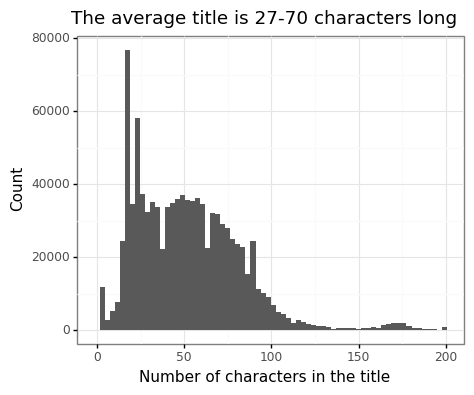

<ggplot: (8787026874884)>

In [51]:
g = (ggplot(plot_df, aes(x="title_length")) + 
     geom_histogram(bins=70) + 
     theme_bw() +
     theme(figure_size=(5, 4)) +
     ggtitle("The average title is 27-70 characters long") +
     xlab("Number of characters in the title") + 
     ylab("Count"))
g

## Content

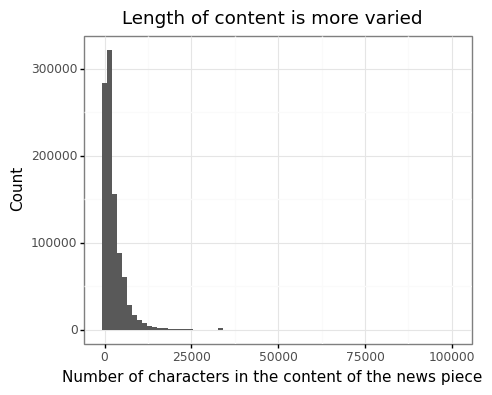

<ggplot: (8760340680903)>

In [38]:
g = (ggplot(plot_df, aes(x="content_length")) + 
     geom_histogram(bins=70) + 
     theme_bw() +
     theme(figure_size=(5, 4)) +
     ggtitle("Length of content is more varied") +
     xlab("Number of characters in the content of the news piece") + 
     ylab("Count"))
g

It helps to plot the x-axis on a log scale

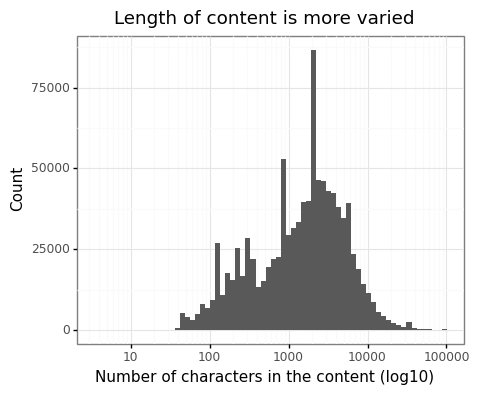

<ggplot: (8760467908831)>

In [39]:
g = (ggplot(plot_df, aes(x="content_length")) + 
     geom_histogram(bins=70) + 
     theme_bw() +
     theme(figure_size=(5, 4)) +
     ggtitle("Length of content is more varied") +
     scale_x_continuous(trans="log10", labels=lambda x: [int(xx) for xx in x]) +
     xlab("Number of characters in the content (log10)") + 
     ylab("Count"))
g

## Length of content per news type

/opt/conda/lib/python3.8/site-packages/plotnine/facets/facet.py:390: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


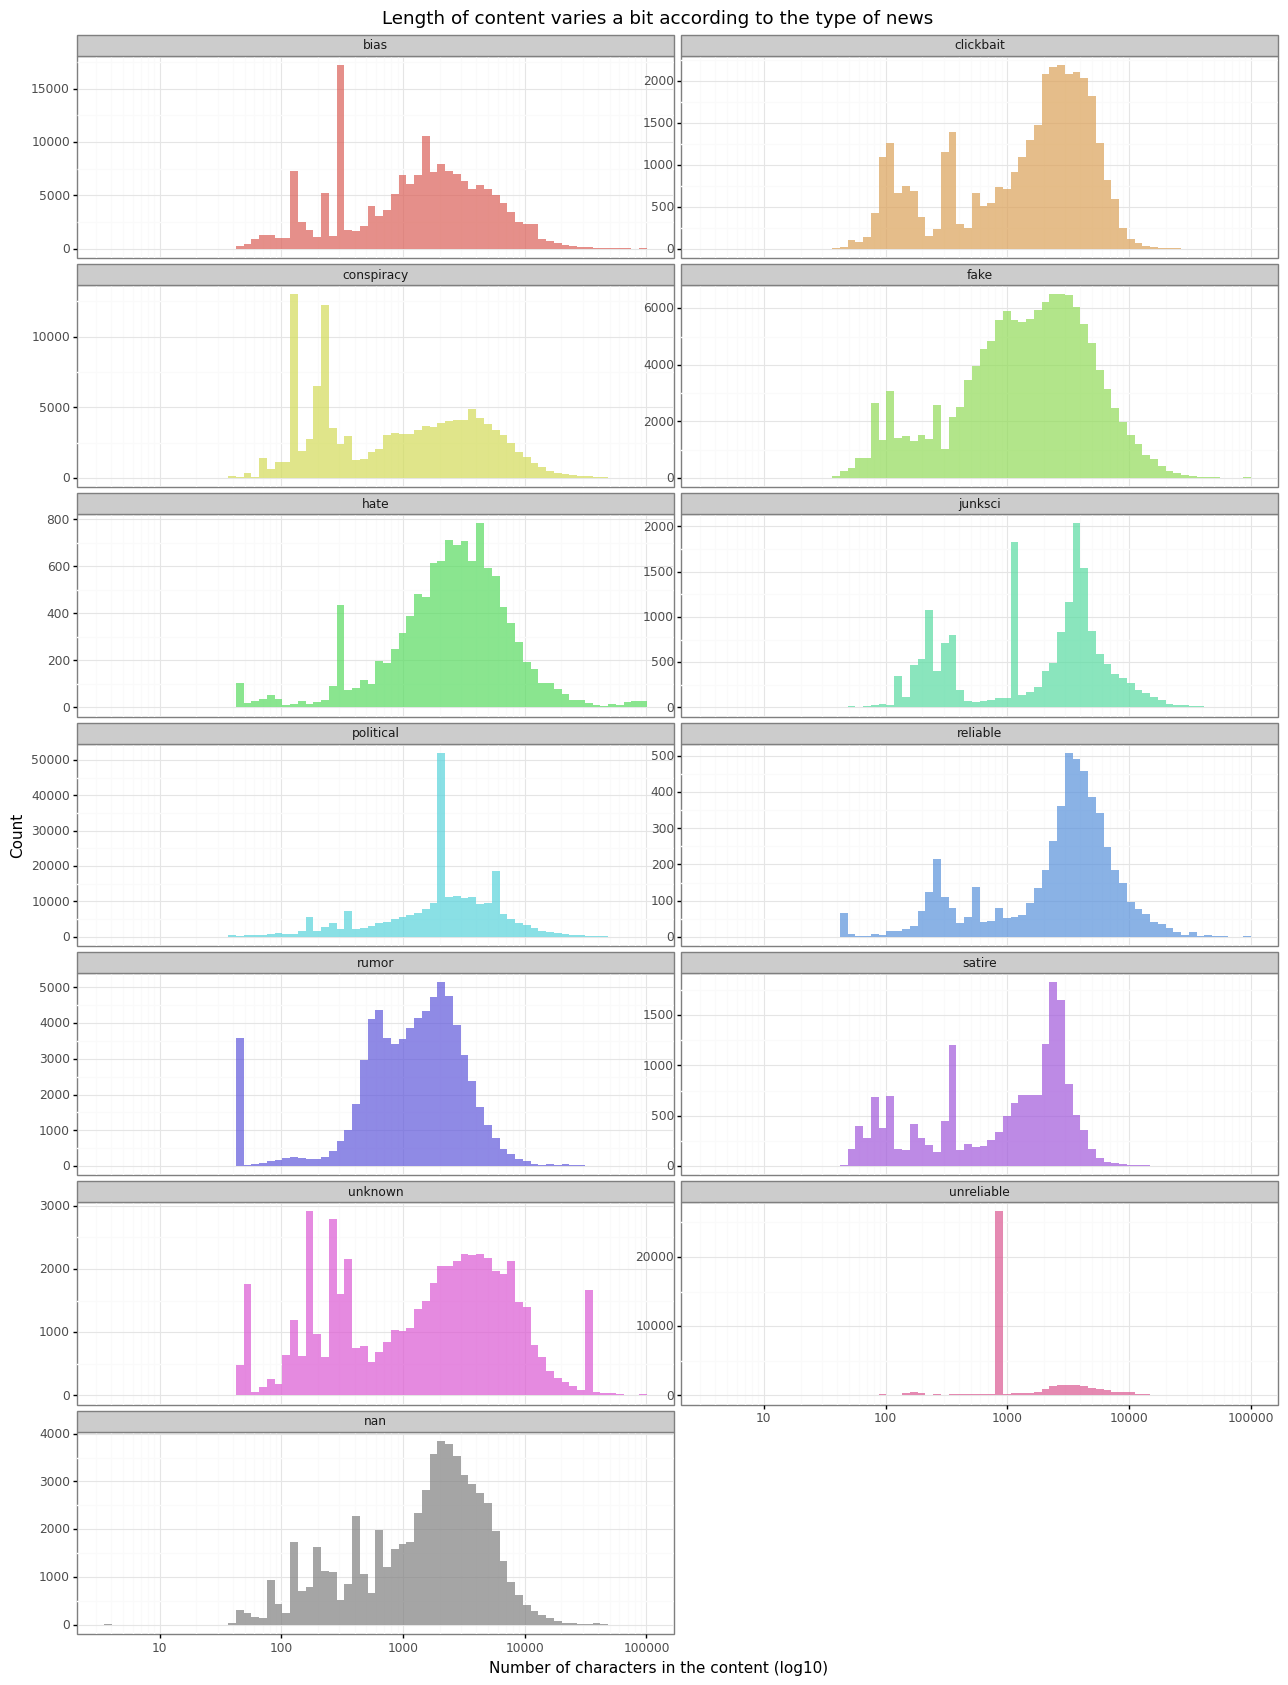

<ggplot: (8760499310279)>

In [43]:
g = (ggplot(plot_df, aes(x="content_length", fill="type")) + 
     geom_histogram(bins=70, alpha=0.7) + 
     theme_bw() +
     theme(figure_size=(5*3+0.5, 4*5+0.5)) +
     ggtitle("Length of content varies a bit according to the type of news") +
     scale_x_continuous(trans="log10", labels=lambda x: [int(xx) for xx in x]) +
     scale_fill_discrete(guide=False) +
     xlab("Number of characters in the content (log10)") + 
     ylab("Count") + 
     facet_wrap("~ type", ncol=2, scales="free_y"))
g